In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)

    def forward(self, data):
        x, adj = data.x, data.adj
        
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
earliest_stop = 5000
tolerance = 0.02

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'CiteSeer'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
).to(device)

# optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.01)
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=5e-4, lr=0.01)

In [4]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > max(2 * early_stop_win_size, earliest_stop):
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
#         if val_acc_current < val_acc_previous - tolerance:
        if val_acc_current < np.max(val_acc) - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.30833333333333335 validation acc = 0.238 , loss = 11.36902141571045
1000 training acc = 1.0 validation acc = 0.53 , loss = 0.0017456392524763942
2000 training acc = 1.0 validation acc = 0.592 , loss = 0.00091331428848207
3000 training acc = 1.0 validation acc = 0.626 , loss = 0.0005857803043909371
4000 training acc = 1.0 validation acc = 0.63 , loss = 0.0004654963850043714
5000 training acc = 1.0 validation acc = 0.646 , loss = 0.0004194577632006258
6000 training acc = 1.0 validation acc = 0.66 , loss = 0.00040760834235697985
7000 training acc = 1.0 validation acc = 0.66 , loss = 0.00039701859350316226
8000 training acc = 1.0 validation acc = 0.652 , loss = 0.00039245287189260125
9000 training acc = 1.0 validation acc = 0.654 , loss = 0.0003927389916498214


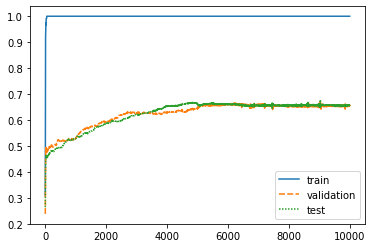

In [5]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [6]:
spio.savemat('../variables/'+ name +'/GCNConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [7]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.6580
Test Accuracy: 0.6570


In [8]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.7825


In [11]:
# this is for Adam optimizer
test_acc_all = [0.6700, 0.6410, 0.6680, 0.6640, 0.6570]
test_auc_all = [0.7890, 0.7781, 0.7902, 0.7861, 0.7825]

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.66
0.7851799999999999
0.010488088481701525
0.004426014008111596
